In [1]:
import rasterio
import numpy as np
import h5py
import os
from matplotlib import pyplot as plt
import cv2

# Helper Functions

In [2]:
def im2double(im):
    min_val = np.min(im.ravel())
    max_val = np.max(im.ravel())
    out = (im.astype('float') - min_val) / (max_val - min_val)
    return out

In [3]:
def readTifImg(fn):
    data = rasterio.open(fn, 'r').read(1)
    return data

In [4]:
def resize400Img(img):
    # cut. Hard-code on l8
    data = img[0:1011, 186:1197]
    return cv2.resize(data, (400, 400))

In [5]:
def get2DMaskArray(mask):
    if (mask.max() == 255):
        mask2D = mask // 255
    else:
        mask2D = 1 - mask
    if (mask2D.shape != [400,400]):
        mask2D = cv2.resize(mask2D, (400,400))
    return mask2D

In [6]:
def addCloudMaskOverData(data, mask):
    maskedData = np.copy(data)
    maskedData[mask == 0] = 0
    return maskedData

In [7]:
def getContinousL8Data(dbPath):
    for _, listInputs, __ in os.walk(dbPath):
        break
    sorted(listInputs)
    for i in range(len(listInputs)):
        listInputs[i] =  os.path.join(dbPath, listInputs[i]) + '/' + listInputs[i]
    
    cloudPath = '../Landsat8/CloudMaskExamples/'
    for _, __, listMasks in os.walk(cloudPath):
        break
    nMask = len(listMasks)
    for i in range(nMask):
        listMasks[i] = os.path.join(cloudPath, listMasks[i])
    
    nBands = len(bandDef)
    nInput = len(listInputs) - 1
    lInput1 = np.zeros((nMask*nBands,imgSize,imgSize,1),dtype=np.float32)
    lInput2 = np.zeros((nMask*nBands,imgSize,imgSize,1),dtype=np.float32)
    lInput3 = np.zeros((nMask*nBands,imgSize,imgSize,1),dtype=np.float32)
    lInput4 = np.zeros((nMask*nBands,imgSize,imgSize,1),dtype=np.float32)
    lInput5 = np.zeros((nMask*nBands,imgSize,imgSize,1),dtype=np.float32)    
    lOutput = np.zeros((nMask*nBands,imgSize,imgSize,1),dtype=np.float32)
    lMasked = np.zeros((nMask*nBands,imgSize,imgSize,1),dtype=np.float32)
    
    p = -1
    for i in range(nMask):
        for b in range(nBands):
            p += 1
            lInput1[p, :, :, 0] = resize400Img(readTifImg(listInputs[0] + '_' + bandDef[b] + '.TIF'))
            lInput2[p, :, :, 0] = resize400Img(readTifImg(listInputs[1] + '_' + bandDef[b] + '.TIF'))
            lInput3[p, :, :, 0] = resize400Img(readTifImg(listInputs[2] + '_' + bandDef[b] + '.TIF'))
            lInput4[p, :, :, 0] = resize400Img(readTifImg(listInputs[3] + '_' + bandDef[b] + '.TIF'))
            lInput5[p, :, :, 0] = resize400Img(readTifImg(listInputs[4] + '_' + bandDef[b] + '.TIF'))
            lOutput[p, :, :, 0] = resize400Img(readTifImg(listInputs[5] + '_' + bandDef[b] + '.TIF'))
            
            mask = get2DMaskArray(readTifImg(listMasks[i]))
            lMasked[p, :, :, 0] = addCloudMaskOverData(lOutput[p, :, :, 0], mask)
    
    ratio = max(lInput1.max(), lInput2.max(), lInput3.max(), lInput4.max(), lInput5.max(), lMasked.max(), lOutput.max())
    
    lInput1 /= ratio
    lInput2 /= ratio
    lInput3 /= ratio
    lInput4 /= ratio
    lInput5 /= ratio
    lMasked /= ratio
    lOutput /= ratio
    
    return lInput1, lInput2, lInput3, lInput4, lInput5, lMasked, lOutput 

# Dataset generator

In [10]:
dbFolderName = '../Landsat8/ContinousWithSentinel1Ref/'

bandDef = ['B7', 'B6', 'B5', 'B4', 'B3']
imgSize = 400

In [11]:
cloudPath = '../Landsat8/CloudMaskExamples/'
for _, __, listMasks in os.walk(cloudPath):
    break
nMask = len(listMasks)
nBands = len(bandDef)
    
for _, listDir, __ in os.walk(dbFolderName):
    break
    
nData = len(listDir)

lInput1 = np.zeros((nData*nMask*nBands,imgSize,imgSize,1),dtype=np.float32)
lInput2 = np.zeros((nData*nMask*nBands,imgSize,imgSize,1),dtype=np.float32)
lInput3 = np.zeros((nData*nMask*nBands,imgSize,imgSize,1),dtype=np.float32)
lInput4 = np.zeros((nData*nMask*nBands,imgSize,imgSize,1),dtype=np.float32)
lInput5 = np.zeros((nData*nMask*nBands,imgSize,imgSize,1),dtype=np.float32)    
lOutput = np.zeros((nData*nMask*nBands,imgSize,imgSize,1),dtype=np.float32)
lMasked = np.zeros((nData*nMask*nBands,imgSize,imgSize,1),dtype=np.float32)
p = -1


for folder in listDir:
    in1, in2, in3, in4, in5, masked, out = getContinousL8Data(os.path.join(dbFolderName, folder))
    for i in range(in1.shape[0]):
        p += 1
        lInput1[p, :, :, 0] = im2double(cv2.equalizeHist((in1[i, :, :, 0] * 255.).astype('uint8')))
        lInput2[p, :, :, 0] = im2double(cv2.equalizeHist((in2[i, :, :, 0] * 255.).astype('uint8')))
        lInput3[p, :, :, 0] = im2double(cv2.equalizeHist((in3[i, :, :, 0] * 255.).astype('uint8')))
        lInput4[p, :, :, 0] = im2double(cv2.equalizeHist((in4[i, :, :, 0] * 255.).astype('uint8')))
        lInput5[p, :, :, 0] = im2double(cv2.equalizeHist((in5[i, :, :, 0] * 255.).astype('uint8')))
        lMasked[p, :, :, 0] = im2double(cv2.equalizeHist((masked[i, :, :, 0] * 255.).astype('uint8')))
        lOutput[p, :, :, 0] = im2double(cv2.equalizeHist((out[i, :, :, 0] * 255.).astype('uint8')))

/home/anhldt/.local/lib/python3.6/site-packages/rasterio/__init__.py:217: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)


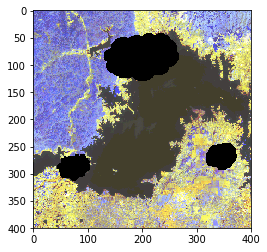

In [22]:
x = 5
rgb = np.dstack((lMasked[3*x,:,:,0],lMasked[3*x+1,:,:,0],lMasked[3*x+2,:,:,0]))
plt.imshow(rgb)

In [ ]:
import h5py
f = h5py.File('data.hdf5', 'w')
f.create_dataset('in1',data=lInput1)
f.create_dataset('in2',data=lInput2)
f.create_dataset('in3',data=lInput3)
f.create_dataset('in4',data=lInput4)
f.create_dataset('in5',data=lInput5)
f.create_dataset('masked',data=lMasked)
f.create_dataset('out',data=lOutput)
f.close()